In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

data_name = 'CIFAR10_RES'

In [2]:

# Transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load train set
train_set = datasets.CIFAR10('../', train=True, download=True, transform=transform_train)

# Load test set
test_set = datasets.CIFAR10('../', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(test_set)

10000

In [4]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.9 * len(train_set))  # 90% training
val_size = len(train_set) - train_size  # 10% validation

# Split the dataset
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

In [5]:
len(val_dataset)

5000

In [6]:
batch_size = 8

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

In [7]:
from resshap import train_model

train_model(width=32, height=32, superpixel_size=2, train_dataloader=train_dataloader,
                val_dataloader=val_dataloader, data_name=data_name, num_classes=10,
                resnet_model=None, optimizer_train=None, current_epoch=1,
                max_num_epochs=300, learning_rate=1e-04, num_samples=4,
                alpha=1, beta=8,
                patience=10)

In [7]:
import torch
import torch.nn as nn
from resshap import ResNet18
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

softmax = nn.Softmax(dim=1)

small_width = 32 // 2
small_height = 32 // 2
num_features = small_width * small_height
    
resnet_model = ResNet18(10, num_features).to(device)

torch.cuda.empty_cache()

resnet_model.load_state_dict(torch.load(f'{data_name}/{data_name}.model'))

print('*** Testing : ****')
resnet_model.eval()

count = 0

list_prediction = []
list_pob_pred = []
y_test = []

with torch.no_grad():
    for i, data in tqdm(list(enumerate(test_dataloader))):
        inputs, labels = data
        labels = torch.nn.functional.one_hot(labels, num_classes=10).float()
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = softmax(resnet_model(inputs))

        preds = torch.max(outputs, dim=-1)[1]
        list_pob_pred.extend(outputs.tolist())

        list_prediction.extend(preds.tolist())

        count+= torch.sum(preds == torch.max(labels, dim=-1)[1])

        y_test.extend(torch.max(labels, dim=-1)[1].tolist())

        torch.cuda.empty_cache()


    roc = roc_auc_score(
                y_test,
                list_pob_pred,
                multi_class="ovr",
                average="weighted",
            )
    prec = precision_score(y_test, list_prediction, average='macro')
    recall = recall_score(y_test, list_prediction, average='macro')
    f_score = f1_score(y_test, list_prediction, average='macro')

print('AUC is : {},  prec {},  recall {}, f-score {}' .format(roc, prec, recall, f_score))

*** Testing : ****


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:50<00:00, 24.92it/s]


AUC is : 0.9676163666666667,  prec 0.7708907521685916,  recall 0.7375, f-score 0.737925133235799


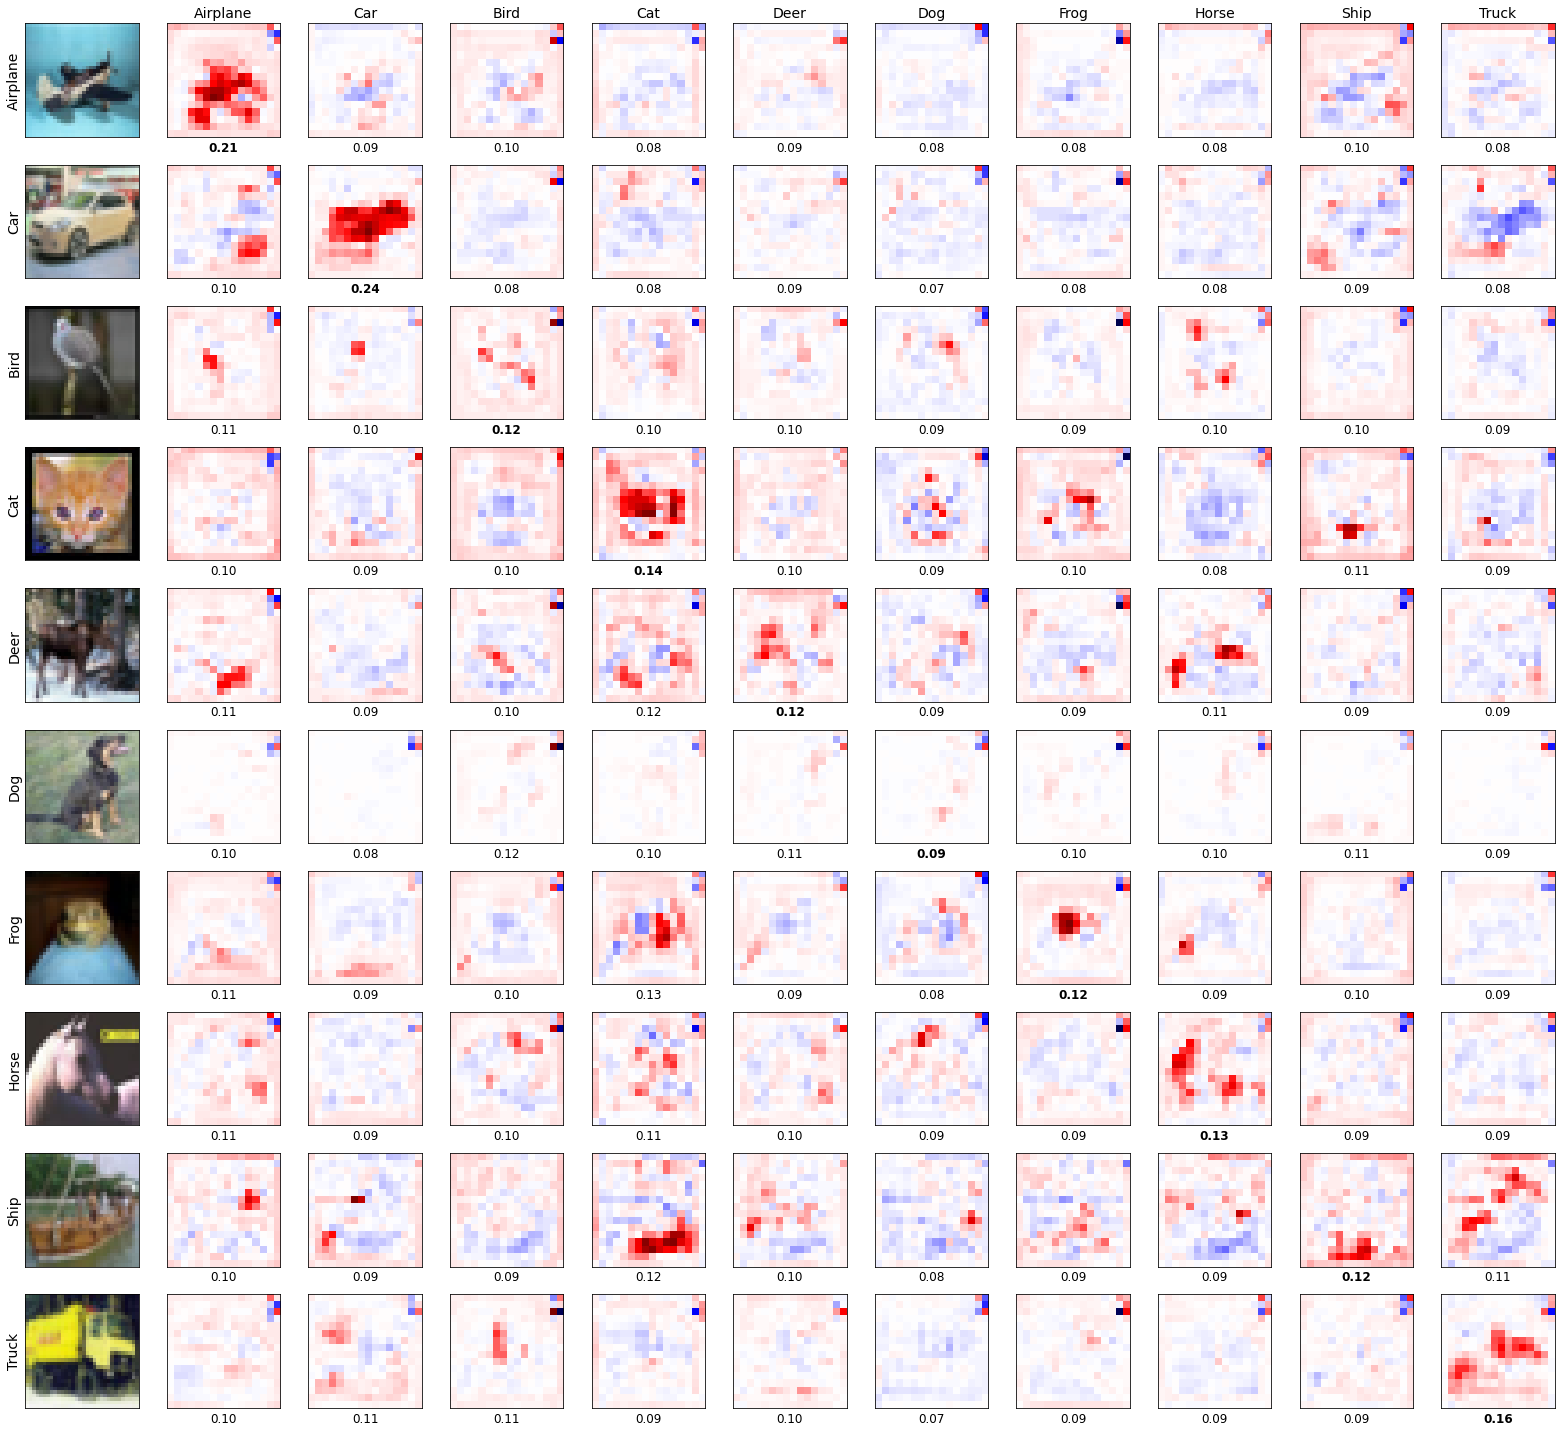

In [8]:
import matplotlib.pyplot as plt
import numpy as np

targets = np.array(test_set.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*[test_set[ind] for ind in inds])
x = torch.stack(x)

values = resnet_model.forward_resnet(x.to(device)).cpu().data.numpy()

pred = softmax(resnet_model(
    x.to(device)
)).cpu().data.numpy()

num_classes = 10
fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
        else:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

plt.tight_layout()
plt.show()